# Fourier methods
> Fourier methods using Python

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]

The Fourier transform (FT) for a well-behaved functions $f$ is defined as:

$$f(k) = \int e^{-ikx} f(x) ~dx$$

The inverse FT is then 

$$f(x) = \frac{1}{2\pi} \int e^{ikx} f(k) ~dk$$



## Discrete Fourier transforms (DFTs)


If the function is periodic in real space, $f(x+L) = f(x)$, then the Fourier space is discrete with spacing $\frac{2\pi}{L}$. Moreover, if the real space is periodic as well as discrete with the spacing $h$, then the Fourier space is discrete as well as bounded.  

$$f(x) = \sum e^{ikx} f(k) ~dk~~~~~~      \text{where } k = \Bigg[ -\frac{\pi}{h}, \frac{\pi}{h}\Bigg];~~ \text{with interval} \frac{2\pi}{L} $$


This is very much in line with crystallography with $ [ -\frac{\pi}{h}, \frac{\pi}{h} ]$ being the first Brillouin zone. So we see that there is a concept of the maximum wavenumber $ k_{max}=\frac{\pi}{h} $, we will get back to this later in the notes. Usually in computations we need to find FT of discrete function rather than of a well defined analytic function. Since the real space is discrete and periodic, the Fourier space is also discrete and periodic or bounded. Also, the Fourier space is continuous if the real space is unbounded. If the function is defined at $N$ points in real space and one wants to calculate the function at $N$ points in Fourier space, then **DFT** is defined as 

$$f_k = \sum_{n=0}^{N-1} f_n ~ e^{-i\frac{2\pi~n~k}{N}}$$

while the inverse transform of this is

$$f_n = \frac1N \sum_{n=0}^{N-1} f_k ~ e^{~i\frac{2\pi~n~k}{N}}$$

To calculate each $f_n$ one needs $N$ computations and it has to be done $N$ times, i.e, the algorithm is simply $\mathcal{O}(N^2)$. This can be implemented numerically as a matrix multiplication, $f_k = M\cdot f_n$, where $M$ is a $N\times N$ matrix.


## Fast fourier tranforms (FFTs)

The discussion here is based on the Cooley-Tukey algorithm. FFTs improves on DFTs by exploiting their symmetries.

$$ \begin{align}
f_k &= \sum_{n=0}^{N-1} f_n  e^{-i~\frac{2\pi~k~n}{N}} \\
&= \sum_{n=0}^{N/2-1} f_{2n} e^{-i~\frac{2\pi~k~2n}{N}} &+ \sum_{n=0}^{N/2-1} f_{2n + 1} e^{-i~\frac{2\pi~k~(n+1)}{N}}\\
&= \sum_{n=0}^{N/2 - 1} f_{2n} e^{-i~\frac{2\pi k~n}{N/2}} &+ e^{-i\frac{2\pi k}{N}} \sum_{n=0}^{N/2 - 1} f_{2n + 1} e^{-i~\frac{2\pi~k~n~}{N/2}}\\
&=\vdots &\vdots
\end{align}$$

We can use the symmetry property, from the definition, $f_{N+k} = f_k$. Notice that, because of the tree structure, there are $\ln_2 N$ stages of the calculation. By applying the method of splitting the computation in two halves recursively, the complexity of the problem becomes  $\mathcal{O}(N \ln N)$  while the naive algorithm is $\mathcal{O}(N^2)$. Below we will look at a simple implementation of FFT. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def testFFT(x):
    ''' FFT in 1d  '''
    N = x.shape[0]
    if N % 2 > 0:
        raise Exception('x must have even size')
    elif N <= 16: 
        ''' this is the naive implementation using matrix multiplication'''
        n = np.arange(N)
        k = n.reshape((N, 1))
        M = np.exp(-2j * np.pi * k * n / N)
        return np.dot(M, x)
    else:
        M1 = testFFT(x[::2])
        M2 = testFFT(x[1::2])
        fac = np.exp(-2j*np.pi*np.arange(N)/N)
        return np.concatenate([M1+fac[:N/2]*M2, M1+fac[N/2:]*M2])

In [3]:
x = np.random.random(1024)
#np.allclose(np.fft.fftn(x), testFFT(x))

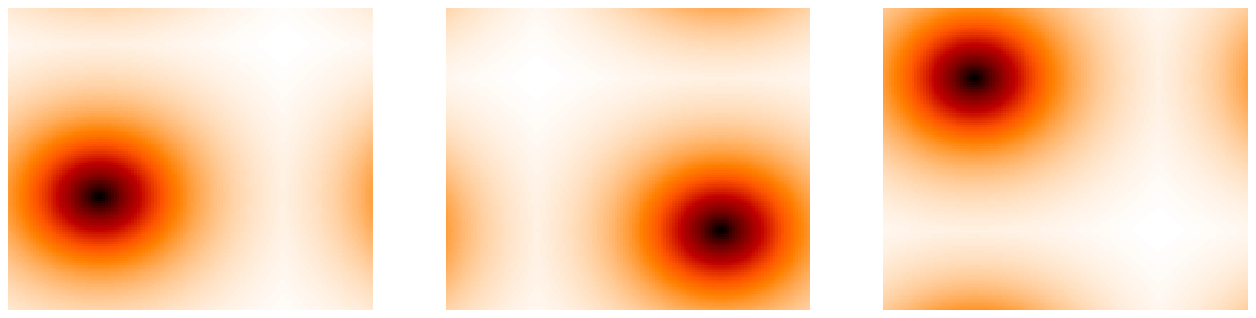

In [4]:
# TRANSLATION by e^{ikr}!
L, N = 64, 128       
ll =  np.linspace(0, L, N)    
x, y = np.meshgrid(ll, ll)

# Fourier grid.
kx = 2 * np.pi / L * np.concatenate((np.arange(0, N/2+1,1),np.arange(-N/2+1, 0, 1)))  # k = (2\pi)/L
ky = 2 * np.pi / L * np.concatenate((np.arange(0, N/2+1,1),np.arange(-N/2+1, 0, 1)))
kx, ky = np.meshgrid(kx, ky) 

def plotFirst(x, y, sig, n_):
    sp =  f.add_subplot(1, 3, n_ )
    plt.pcolormesh(x, y, np.real(sig), cmap=plt.cm.gist_heat_r)
    plt.axis('off');
    
f = plt.figure(figsize=(20, 5), dpi=80);  
rr = np.sqrt( (x - L/2)*(x - L/2) + (y - L/2)*(y - L/2) )
sig = np.fft.fftn(np.exp(-0.1*rr))

xx = ([-L/4, L/2, -L/2,])
yy = ([-L/8, -L/9, L/2])
for i in range(3):
    kdotr = kx*xx[i] + ky *yy[i]
    sig = sig*np.exp(-1j*kdotr)
    plotFirst(x, y, np.fft.ifftn(sig), i+1)

## More examples
### Sampling: Aliasing error

We saw that because of the smallest length scale, $h$, in the real space there is a corresponding largest wave-vector, $k_{max}$ in the Fourier space. The error is because of this $k_{max}$ and a signal which has $k>k_{max}$ can not be distinguished on this grid. In the given example, below, we see that if the real space has 10 points that one can not distinguish between $sin(2\pi x/L)$ and $sin(34 \pi x/L)$. In general, $sin(k_1 x)$ and $sin(k_2 x)$ can not be distinguished if $k_1 -k_2$ is a multiple of $\frac{2\pi}{h}$. This is a manifestation of the gem called the sampling theorem which is defined, as on wikipedia:

If a function x(t) contains no frequencies higher than B hertz, it is completely determined by giving its ordinates at a series of points spaced 1/(2B) seconds apart.

In [5]:
L, N = 1, 16
x = np.arange(0, L, L/512)
xx = np.arange(0, L, L/N)

def ff(k, x):
    return sin(k*x)

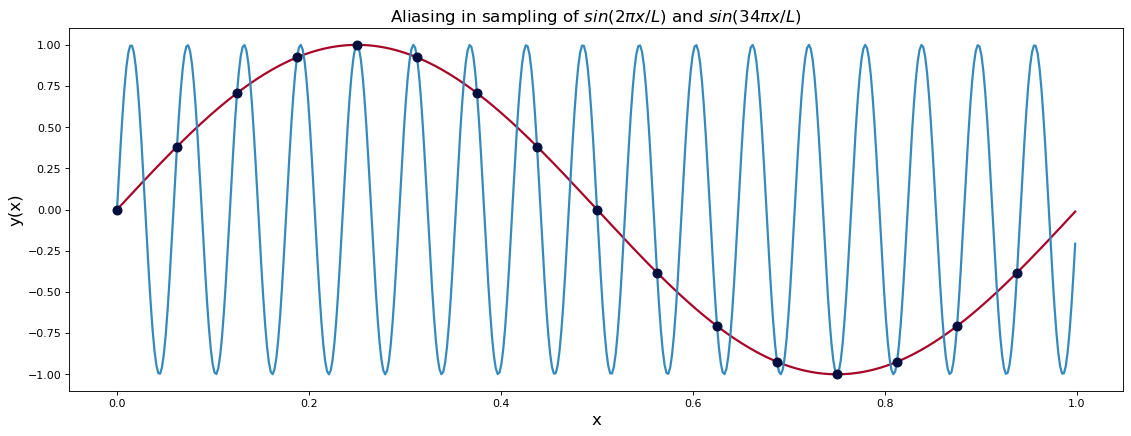

In [6]:
f = plt.figure(figsize=(17, 6), dpi=80);  pi=np.pi; sin=np.sin; cos=np.cos

plt.plot(x, ff(x, 2*pi), color="#A60628", linewidth=2);
plt.plot(x, ff(x, 34*pi), color="#348ABD", linewidth=2);
plt.plot(xx, ff(xx, 2*pi), 'o', color="#020e3e", markersize=8)
plt.xlabel('x', fontsize=15); plt.ylabel('y(x)', fontsize=15);
plt.title('Aliasing in sampling of $sin(2\pi x/L)$ and $sin(34 \pi x/L)$', fontsize=15);

 ### Differentiation
 
 In this section we will use the in-built FFT modules of numpy and then perform differentiation. Differentiation in Fourier space is trivial, $\mathbf{\nabla}_{\alpha}$ gets replaced by $ik_{\alpha}$. Steps involved are
 
* FFT the function to be differentiated.
* multiply by suitable numbers of $ik$
* IFFT on the resulting thing to get the differentiated function in real space.

In [7]:
def f1(kk, x):
    return cos(kk*x)


/data/septal/rs2004/software/anaconda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


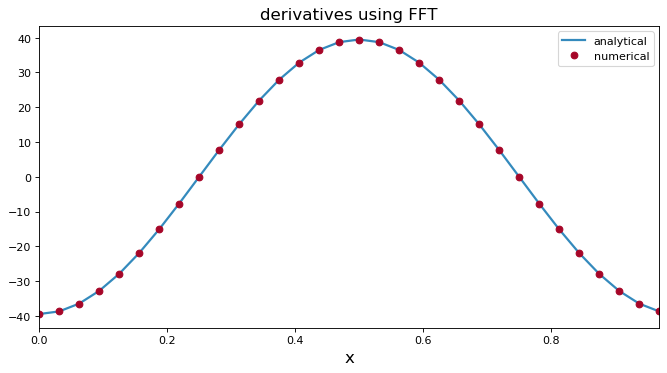

In [8]:
f = plt.figure(figsize=(10, 5), dpi=80);  

L, N = 1, 32
kk   = 2*pi/L
x = np.arange(0, N)*(L/N)     
k = np.concatenate(( np.arange(0, N/2+1,1), np.arange(-N/2+1, 0, 1) ))*(2*pi/L)

fk = np.fft.fft(f1(kk, x))         
f1_kk = -k*k*fk               
f1_xx = np.fft.ifft(f1_kk)

 
plt.plot(x, -f1(kk, x)*kk*kk, color="#348ABD", label = 'analytical', linewidth=2)          
plt.plot(x, f1_xx, 'o', color="#A60628", label = 'numerical', markersize=6)     
plt.legend(loc = 'best')
plt.xlabel('x', fontsize=15)
plt.title('derivatives using FFT', fontsize=15)
plt.xlim([0, max(x)]);

There are additional symmetry properties for a real function. Wavenumbers corresponding to $j$ and $N-j$ are same and hence we only need to consider wavenumber till N/2!

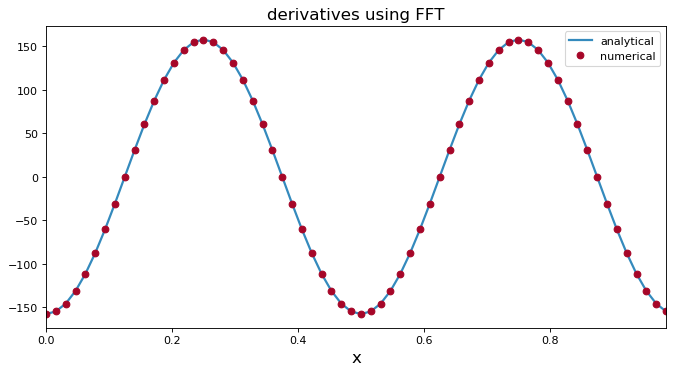

In [9]:
# since we know that function is real, then we could save some time and memory by using real FFTs.
f = plt.figure(figsize=(10, 5), dpi=80);  

L, N = 1, 64     
x = np.arange(0, L, L/N)  
kk   = 4*pi/L
k =  np.arange(0, N/2 + 1)*(2*pi/L)

# k[2] = 0 # all the pattern is dead at a particular k mode which coooresponds to the signal!!

fk = np.fft.rfft(f1(kk, x))         
fk = -k*k*fk               
fx = np.fft.irfft(fk)

plt.plot(x, -kk*kk*f1(kk, x), color="#348ABD", label = 'analytical', linewidth=2)          
plt.plot(x, fx, 'o', color="#A60628", label = 'numerical')     
plt.legend(loc = 'best')
plt.xlabel('x', fontsize=15)
plt.title('derivatives using FFT', fontsize=15)
plt.xlim([0, max(x)]);